# MGT 595 Problem Set 3
# Author: Denglin Wu, Joanna Chen

# September 21, 2020


In [ ]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Data manipulation:
We read in data from Problem_Set3.xls. There are three subsheet in this file. They are: Market_proxy (sheet1), 25_Size_BEME_Portfolios (sheet2), 49_Industry_Portfolios (sheet3). 

Sheet2 consists of three datasets: average value weights returns monthly (A:Z), average size of each portfolio monthly (AB:BA)and average BE/ME of each portfolio annually (BC:CB).

Sheet3 consists of three datasets as well: average value weighted returns monthly (A:AX), average firm size monthly (AZ:CW) and average BE/ME annually (CY:EV). 

In [ ]:
pd.read_excel("Problem_Set3.xls")
#--------------------Read Sheet 1--------------------
sheet1=pd.read_excel("Problem_Set3.xls", sheet_name='Market_proxy', 
                     skiprows=5, index_col=None)
sheet1["Date"] = pd.to_datetime(sheet1["Unnamed: 0"], format="%Y%m")
s1 = sheet1.set_index("Date")
s1 = s1.loc[s1.index.dropna()]
s1 = s1.drop("Unnamed: 0", axis = 1)

#--------------------Read Sheet 2--------------------
sheet2_return=pd.read_excel("Problem_Set3.xls", sheet_name='25_Size_BEME_Portfolios', 
                     skiprows=2, index_col=None, usecols="A:Z", na_values=-99.99)
sheet2_return["Date"] = pd.to_datetime(sheet2_return["BE/ME"], format="%Y%m")
s2_return = sheet2_return.set_index("Date")
s2_return = s2_return.loc[s2_return.index.dropna()]
s2_return = s2_return.drop("BE/ME", axis = 1)

sheet2_size = pd.read_excel("Problem_Set3.xls", sheet_name='25_Size_BEME_Portfolios', 
                     skiprows=2, index_col=0, usecols="AB:BA", na_values=-99.99)
sheet2_size = sheet2_size.loc[sheet2_size.index.dropna()]
sheet2_size['Date'] = sheet2_size.index
sheet2_size['Date'] = pd.to_datetime(sheet2_size['Date'], format="%Y%m")
s2_size = sheet2_size.set_index("Date")
# s2_size['year'] = s2_size.index.year

sheet2_BEME = pd.read_excel("Problem_Set3.xls", sheet_name='25_Size_BEME_Portfolios', 
                     skiprows=2, index_col=0, usecols="BC:CB", na_values=-99.99)
sheet2_BEME = sheet2_BEME.loc[sheet2_BEME.index.dropna()]
sheet2_BEME['Date'] = sheet2_BEME.index
sheet2_BEME['Date'] = pd.to_datetime(sheet2_BEME['Date'], format="%Y")
s2_BEME = sheet2_BEME.set_index("Date")
# s2_BEME['year'] = s2_BEME.index.year

#--------------------Merge s2_return with s1--------------------
# s2_return: 1073*25, s1: 1073*2, inner join
s2_return_s1 = pd.merge(s2_return, s1, how='inner', left_index=True, right_index=True)
#--------------------Read Sheet 3--------------------
sheet3_return=pd.read_excel("Problem_Set3.xls", sheet_name='49_Industry_Portfolios', 
                     skiprows=6, index_col=None, usecols="A:AX", na_values=-99.99)
sheet3_return["Date"] = pd.to_datetime(sheet3_return["Unnamed: 0"], format="%Y%m")
s3_return = sheet3_return.set_index("Date")
s3_return = s3_return.loc[s3_return.index.dropna()]
s3_return = s3_return.drop("Unnamed: 0", axis = 1)

sheet3_size = pd.read_excel("Problem_Set3.xls", sheet_name='49_Industry_Portfolios', 
                     skiprows=6, index_col=0, usecols="AZ:CW", na_values=-99.99)
sheet3_size = sheet3_size.loc[sheet3_size.index.dropna()]
sheet3_size['Date'] = sheet3_size.index
sheet3_size['Date'] = pd.to_datetime(sheet3_size['Date'], format="%Y%m")
s3_size = sheet3_size.set_index("Date")
s3_size['year'] = s3_size.index.year

sheet3_BEME = pd.read_excel("Problem_Set3.xls", sheet_name='49_Industry_Portfolios', 
                     skiprows=6, index_col=0, usecols="CY:EV", na_values=-99.99)
sheet3_BEME = sheet3_BEME.loc[sheet3_BEME.index.dropna()]
sheet3_BEME['Date'] = sheet3_BEME.index
sheet3_BEME['Date'] = pd.to_datetime(sheet3_BEME['Date'], format="%Y")
s3_BEME = sheet3_BEME.set_index("Date")
s3_BEME['year'] = s3_BEME.index.year

# Part I:  The 49 Industry Portfolio

## a) Consider the cross-sectional regression, 
$$
\mathrm{R}_{\mathrm{i}}=\gamma_{0}+\gamma_{\mathrm{M}} \beta_{\mathrm{iM}}+\eta_{\mathrm{i}}
$$
where $\gamma _{0}$ and $\gamma_{M}$ are  regression  parameter and $
\beta_{\mathrm{iM}}=\operatorname{cov}\left(\mathrm{R}_{\mathrm{i}}, \mathrm{R}_{\mathrm{M}}\right) / \sigma^{2}\left(\mathrm{R}_{\mathrm{M}}\right)
$.  If  the CAPM  holds,  then  what  should $\gamma_{0}$ and $\gamma_{M}$  equal  (for  both  the  Sharpe/Lintner  and Black versions)?

Sharpe/Lintner's estimation:
$$
r_{i t}-r_{f t}=\alpha_{i}+\beta_{i}\left(R_{m t}-r_{f t}\right)+\epsilon_{i t}
$$
Black's estimation:
$$
r_{i t}=\alpha_{i}+\beta_{i}\left(R_{m t}\right)+\epsilon_{i t}.
$$

Theoretically if CAPM holds, we know that the return of an asset could be explained by 1) the return of a uncorrelated asset, and 2) the excess return of the market to that uncorrelated asset.

While we could use any uncorrelated asset for the equation, one frequently used asset is the risk-free asset.

For the Shapre/Linter's estimation: since the excess return has been taken into account, the $\beta$ value should solely explain the asset's return. Therefore, $\gamma_0$ should equal 0, while $\gamma_1$ should equal Market Risk Premium, the excess return of the market to the risk-free asset.

For Black's estimation: since it is assumed that there's no risk-free asset, $\gamma_0$ should equal the return of the uncorrelated asset, Rz, times (1-$\beta$), therefore $\gamma_0$ = Rz*(1-$\beta$). The coefficient term for Beta should be the Market Return, therefore $\gamma_1$ = Rm.

## b)   Estimate  $\gamma_{0}$ and $\gamma_{M}$  using  the  approach  pioneered  by  Fama  and  MacBeth.  

The following  is a brief outline of the procedure:

1. Estimate $\beta_{iM}$ for each portfolio (denote the estimate $b_{iM}$). Assume that the betas do not change over time; hence, you can estimate the betas using full-period OLS regressions.

2. Each month estimate the cross-sectional regression, $
\mathrm{R}_{\mathrm{it}}=\gamma_{0 \mathrm{t}}+\gamma_{\mathrm{Mt}} \mathrm{b}_{\mathrm{iM}}+\mathrm{\eta}_{\mathrm{it}}
$. Note: the estimated beta ($b_{iM}$ ) is the same for every time period (i.e., it has no time subscript).

3.	Compute the time series average of the estimates of $\gamma_0$ and $\gamma_M$. In addition, compute the standard error and t-stat of the time series averages. 

Can you reject the hypothesis that the proxy for the market portfolio is mean variance efficient? Why or why not?

time series regression:
$$
r_{i t}-r_{f t}=\alpha_{i}+\beta_{i}\left(R_{mt}-r_{ft}\right)+\varepsilon_{i}
$$

### 1. Estimating Beta

In [ ]:
# merge s1 with s3_return
reg_dt = pd.merge(s1,s3_return, how = 'inner',left_index=True, right_index=True)

# second term with beta coefficient on the RHS of the formula
reg_dt.iloc[:, 2:] = reg_dt.iloc[:, 2:].subtract(reg_dt['RF'], axis = 0)

# average return on the LHS of the formula
avg_return = pd.DataFrame(reg_dt.iloc[:, 2:].mean())
avg_return.columns = ['avg_return']

# estimate betas
beta = []
for pf in avg_return.index:
  x = sm.add_constant(reg_dt['Mkt-RF'])
  y = reg_dt[pf]
  mod = sm.OLS(y,x,missing = 'drop').fit()
  beta.append(mod.params[1])

### 2. Estimating Cross-Sectional Regression

Once we have the betas $\mathrm{b}_{iM}$, we want to see if the beta line up with average returns, in other words, we want to see if there's a 1-1 maping from beta to average returns. 


Cross-sectional regression: $
\mathrm{R}_{\mathrm{it}}=\gamma_{0 \mathrm{t}}+\gamma_{\mathrm{Mt}} \mathrm{b}_{\mathrm{iM}}+\mathrm{\eta}_{\mathrm{it}}.
$

In [ ]:
gamma0 = []
gamma1 = []

x = sm.add_constant(beta)
for Date in reg_dt.index:
  y = reg_dt.loc[Date,:].iloc[2:]
  mod2 = sm.OLS(y,x,missing = 'drop').fit()
  # print(mod2.params)
  gamma0.append(mod2.params[0])
  gamma1.append(mod2.params[1])

# merge date, gamma0, gamma1
df = pd.DataFrame({'Date': reg_dt.index, 'gamma0':gamma0, 'gamma1':gamma1})

### Average of Gamma, Standard Error and T-stat

T-statistic: $$
t=\frac{\bar{x}-\mu_{0}}{s / \sqrt{n}}
$$

In [ ]:
mean_gamma0 = np.mean(gamma0)
mean_gamma1 =np.mean(gamma1)
SE_gamma0 = np.std(gamma0) / np.sqrt(len(gamma0))
SE_gamma1 = np.std(gamma1) / np.sqrt(len(gamma1))

# t-test
# for gamma0, the null hypothesis should be gamma0 = Rf
# for gamma1, the null hypothesis should be gamma1 = 0, with alternative hypothesis being gamma1 > 0
Rf = np.mean(reg_dt['RF'])
t_gamma0 = (mean_gamma0 - Rf) / SE_gamma0
t_gamma1 = (mean_gamma1) / SE_gamma1
print("mean of gamma 0: ", mean_gamma0, "mean of gamma 1: ", mean_gamma1,"SE of gamma0: ", 
      SE_gamma0, "SE of gamma1: ", SE_gamma1, "t-stat for gamma0: ",t_gamma0,
      "t-stat for gamma1: ",t_gamma1)



mean of gamma 0:  0.5195540470580177 mean of gamma 1:  0.23143895345886337 SE of gamma0:  0.19031329516375045 SE of gamma1:  0.2558619728543959 t-stat for gamma0:  1.2480197865233866 t-stat for gamma1:  0.9045461147544931


For our cross-sectional regression $
\mathrm{R}_{\mathrm{it}}=\gamma_{0 \mathrm{t}}+\gamma_{\mathrm{Mt}} \mathrm{b}_{\mathrm{iM}}+\mathrm{\eta}_{\mathrm{it}}.
$

To test the proxy for market protfolio is mean-variance efficient,

$H_0$: $E\left[\gamma_{1}\right]=r_{f}$ and $E\left[\gamma_{M}\right]=
E\left[R_M\right]-r_{f}=0$

$H_1$: $E\left[\gamma_{1}\right] \ne r_{f}$ and $E\left[\gamma_{M}\right]=
E\left[R_M\right]-r_{f} > 0$

In the formula, $n$ = 1069, therefore, the degree of freedom = $n - 1 = 1068$. We looked up the t-table [http://www.math.odu.edu/stat130/t-tables.pdf], $t_{crit} = 1.646$ for one tail with $\alpha = 0.05$ and degree of freedom $= 1000$. Since $t_{\gamma_0}$ = 1.25 and $t_{\gamma_1}$ = 0.90 which are both less than  $t_{crit}$, we fail to reject the null hypothesis and conclude that  the proxy of the market portfolio is not mean-variance efficient.

## c) 	Estimate the cross-sectional regression 
$${ave}\left(\mathrm{R}_{\mathrm{i}}\right)=\gamma_{0}+\gamma_{\mathrm{M}} \mathrm{b}_{\mathrm{iM}}+\mathrm{\eta
}_{\mathrm{i}}
$$  Are the estimates of $\gamma_0$ and $\gamma_M$ different than the average estimates in part b?  Are the standard errors of the estimates of $\gamma_0$ and $\gamma_M$ different than the standard errors of the average estimates in part b? Why or why not? Which method is superior? Why?



In [ ]:
# OLS regression on avg_return and beta
avg_return['beta'] = beta
avg_return

x = sm.add_constant(avg_return['beta'])
mod3 = sm.OLS(avg_return["avg_return"],x, data = avg_return).fit()
mod3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             avg_return   R-squared:                       0.054
Model:                            OLS   Adj. R-squared:                  0.034
Method:                 Least Squares   F-statistic:                     2.687
Date:                Tue, 22 Sep 2020   Prob (F-statistic):              0.108
Time:                        03:00:15   Log-Likelihood:                 24.375
No. Observations:                  49   AIC:                            -44.75
Df Residuals:                      47   BIC:                            -40.97
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.5874      0.100      5.855      0.000       0.386       0.789
beta           0.1495      0.091      1.639      0.108      -0.034       0.333
==============================================================================
Omnibus:                        4.612   Durbin-Watson:                   1.632
Prob(Omnibus):                  0.100   Jarque-Bera (JB):                3.587
Skew:                          -0.474   Prob(JB):                        0.166
Kurtosis:                       3.927   Cond. No.                         9.28
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

By OLS regression, we get $\hat\gamma_0 = 0.5874$ and  $\hat\gamma_1 = 0.1495$. In part (b), using Fama and MacBeth's approach, we get $\hat\gamma0 = 0.5196$ and $\hat\gamma1 = 0.2314$. Estimations from two approachs are similar. 

In part (b), SE of $\gamma_0 = 0.19$ and SE of $\gamma_1 = 0.26$. In part (c), SE of $\gamma_0 = 0.1$ and SE of $\gamma_1 = 0.09$. Because the SE in part (c) is less than ones in part (b),  cross-sectional method is superior.

## d)	Plot the $ave(R_i)$ for the portfolios against their $b_{iM}$.  Does the plot resemble a positive relationship?  What should the plot look like?

(0.0, 2.0)

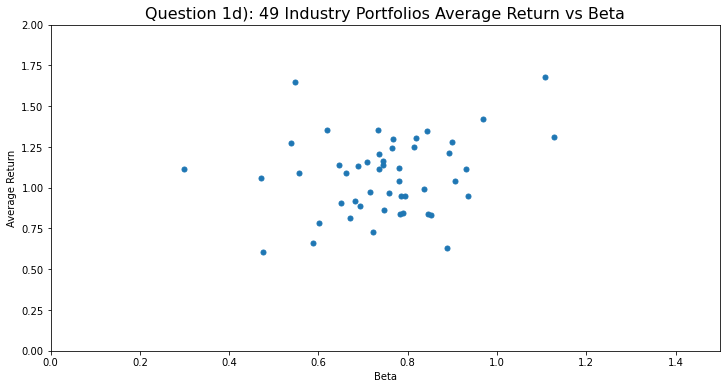

In [ ]:
fig=plt.figure(figsize=(12,6))
plt.plot(avg_return['avg_return'], avg_return['beta'],'.',markersize=10)
plt.xlabel('Beta')
plt.ylabel('Average Return');
plt.title('Question 1d): 49 Industry Portfolios Average Return vs Beta', fontsize=16)
plt.xlim(0, 1.5)
plt.ylim(0, 2)

The plot does resembles a generally positive relationship between the average return and beta value, despite much noise and low linearity. Per CAPM, the average return should be explained solely by beta and the intercept, which should be the return of the uncorrelated asset. Therefore, the plot should be a straight line with intercept of Rf.

## e)	Now, Consider the cross-sectional regression
$$
\mathrm{R}_{\mathrm{i}}=\gamma_{0}+\gamma_{\mathrm{M}} \beta_{\mathrm{iM}}+\gamma_{\mathrm{size}} \ln (\text { size })+\gamma_{\mathrm{B} / \mathrm{M}} \ln (\mathrm{BE} / \mathrm{ME})+\eta_{\mathrm{i}}
$$
where $
\gamma_{0}, \gamma_{\mathrm{M}}, \gamma_{\mathrm{size}}, \text { and } \gamma_{\mathrm{B} / \mathrm{M}}
$ are regression parameters,  $
\beta_{i M}=\operatorname{cov}\left(R_{i}, R_{M}\right) / \sigma^{2}\left(R_{M}\right)
$), and 	size and BE/ME are the average size and  book to market ratio of the portfolio. 

Note that size is provided on a monthly basis, but BE/ME is provided on an annual basis. For simplicity, assume BE/ME within each year is constant so that you have 12 constant BE/ME numbers within each year. Answer the following question.


In [ ]:
# Resize s3_BEME to s3_BEME_monthly
s3_BEME_monthly = s3_size.copy()
s3_BEME_monthly.columns = s3_BEME_monthly.columns.str.replace('.1', '.2')
for pf in s3_BEME_monthly.index:
    s3_BEME_monthly.loc[pf] = s3_BEME.loc[str(pf.year)+'-01-01']

# obtain ln(size)
s3_size_2 = s3_size.drop('year', axis=1)
avg_size = []
for column in s3_size_2:
    avg_size.append(s3_size_2[column].mean())
ln_avg_size = np.log(avg_size)

# obtain ln(BEME)
s3_BEME_monthly_2 = s3_BEME_monthly.drop('year', axis=1)
avg_BEME = []
for column in s3_BEME_monthly_2:
    avg_BEME.append(s3_BEME_monthly_2[column].mean())
ln_avg_BEME = np.log(avg_BEME)

# OLS regression on avg_return and beta / ln(size) / ln(BEME)
avg_return['ln(size)'] = ln_avg_size
avg_return['ln(BEME)'] = ln_avg_BEME

x['ln(size)'] = avg_return['ln(size)']
x['ln(BEME)'] = avg_return['ln(BEME)']
mod4 = sm.OLS(avg_return["avg_return"], x).fit()
mod4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             avg_return   R-squared:                       0.216
Model:                            OLS   Adj. R-squared:                  0.163
Method:                 Least Squares   F-statistic:                     4.125
Date:                Tue, 22 Sep 2020   Prob (F-statistic):             0.0115
Time:                        03:00:16   Log-Likelihood:                 28.965
No. Observations:                  49   AIC:                            -49.93
Df Residuals:                      45   BIC:                            -42.36
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0500      0.237     -0.211      0.833      -0.527       0.427
beta           0.2633      0.094      2.810      0.007       0.075       0.452
ln(size)       0.0751      0.028      2.664      0.011       0.018       0.132
ln(BEME)      -0.0468      0.057     -0.823      0.415      -0.161       0.068
==============================================================================
Omnibus:                       14.088   Durbin-Watson:                   1.620
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               16.137
Skew:                          -1.084   Prob(JB):                     0.000313
Kurtosis:                       4.790   Cond. No.                         84.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

If the CAPM holds, then what should $\gamma_{\mathrm{size}}$ and $\gamma_{B/M}$ equal?

If the CAPM holds, $\gamma_{\mathrm{size}}$ and $\gamma_{B/M}$ should both be equal to 0, since the expected return should be explained by beta and the expected return of uncorrelated asset - the expected return of the risk-free.

## f)	Estimate with Fama MacBeth procedure
The following is a brief outline of the procedure:

1.	Estimate $\beta_{iM}$ for each portfolio. Assume that the betas do not change over time; hence, you can estimate the betas using full-period OLS regressions. (Note:  you have already done this.)

2. Each month estimate th eregression, 
$$
\mathrm{R}_{\mathrm{it}}=\gamma_{0 \mathrm{t}}+\gamma_{\mathrm{Mt}} \mathrm{b}_{\mathrm{iM}}+\gamma_{\mathrm{sizet}} \ln \left([\mathrm{size}]_{\mathrm{t}-1}\right)+\gamma_{\mathrm{B} / \mathrm{Mt}} \ln \left([\mathrm{BE} / \mathrm{ME}]_{\mathrm{t}-1}\right)+\mathrm{n}_{\mathrm{it}}
$$

- Note: You need to lag size and BE/ME appropriately in the regression. This means that size and BE/ME need to be measured ex ante and therefore must be the previous month’s size and previous year’s BE/ME.

- Why is it important that the size and BE/ME characteristics should be lagged values?

3. Compute the time series average of the estimates of $
\gamma_{0}, \gamma_{\mathrm{M}}, \gamma_{\mathrm{size}}, \text { and } \gamma_{\mathrm{B} / \mathrm{M}}
$. In addition compute the standard error and t-stat of the time series averages.

In [ ]:
# 2. Lag size and BE/ME
# We merge s3_size and s3_BEME to make the Part I f) implementation easier
# It would be a left join with key "year"
s3_size_BEME  = pd.merge(s3_size,s3_BEME, 'left', on = 'year')

# Lagging
# https://stackoverflow.com/questions/51136283/pandas-insert-empty-row-at-0th-position
temp = pd.DataFrame([[np.nan] * len(s3_size_BEME.columns)], columns=s3_size_BEME.columns)
s3_size_BEME_lag = temp.append(s3_size_BEME, ignore_index=True)
s3_size_BEME_lag = s3_size_BEME_lag.drop(1069)
s3_size_BEME_lag.index = s3_size.index
s3_size_BEME_lag = s3_size_BEME_lag.drop('year', axis = 1)

for Date in s3_size_BEME_lag.index:
    if Date.year == 1926:
        s3_size_BEME_lag.loc[Date].iloc[50:99] = np.nan
        continue
    s3_size_BEME_lag.loc[Date].iloc[50:99] = s3_BEME.loc[str(Date.year-1)+'-01-01'].iloc[0:49]
    
gamma0_size_BEME = []
gamma1_size_BEME = []
gamma2_size_BEME = []
gamma3_size_BEME = []

reg_dt_2 = pd.merge(reg_dt, s3_size_BEME_lag, how = 'inner',left_index=True, right_index=True)

size_BEME_return = avg_return.copy()
size_BEME_return = size_BEME_return.rename(columns={'avg_return': 'size_BEME_return'})

for Date in reg_dt_2.index:
    temp1 = reg_dt_2.loc[Date,:].iloc[51:100]
    if temp1.isnull().sum() == 49:
        continue
    temp1.index = temp1.index.str.replace('.1', '')
    size_BEME_return['ln(size)'] = np.log(temp1)
    temp2 = reg_dt_2.loc[Date,:].iloc[100:149]
    if temp2.isnull().sum() == 49:
        continue
    temp2.index = temp2.index.str.replace('.2', '')
    size_BEME_return['ln(BEME)'] = np.log(temp2)
    size_BEME_return['size_BEME_return'] = reg_dt_2.loc[Date,:].iloc[2:51]
    y = size_BEME_return['size_BEME_return']
    x = sm.add_constant(size_BEME_return['beta'])
    x['ln(size)'] = size_BEME_return['ln(size)']
    x['ln(BEME)'] = size_BEME_return['ln(BEME)']
    mod5 = sm.OLS(y, x, missing = 'drop').fit()
    gamma0_size_BEME.append(mod5.params[0])
    gamma1_size_BEME.append(mod5.params[1])
    gamma2_size_BEME.append(mod5.params[2])
    gamma3_size_BEME.append(mod5.params[3])

In [ ]:
mean_gamma0_size_BEME = np.mean(gamma0_size_BEME)
mean_gamma1_size_BEME = np.mean(gamma1_size_BEME)
mean_gamma2_size_BEME = np.mean(gamma2_size_BEME)
mean_gamma3_size_BEME = np.mean(gamma3_size_BEME)
SE_gamma0_size_BEME = np.std(gamma0_size_BEME)/np.sqrt(len(gamma0_size_BEME))
SE_gamma1_size_BEME = np.std(gamma1_size_BEME)/np.sqrt(len(gamma1_size_BEME))
SE_gamma2_size_BEME = np.std(gamma2_size_BEME)/np.sqrt(len(gamma2_size_BEME))
SE_gamma3_size_BEME = np.std(gamma3_size_BEME)/np.sqrt(len(gamma3_size_BEME))

# t-test
# for gamma0, the null hypothesis should be gamma0 = Rf
# for gamma1, the null hypothesis should be gamma1 = 0, with alternative hypothesis being gamma1 > 0
# for gamma2, the null hypothesis should be gamma2 = 0
# for gamma3, the null hypothesis should be gamma3 = 0
t_gamma0_size_BEME = (mean_gamma0_size_BEME - Rf) / SE_gamma0_size_BEME
t_gamma1_size_BEME = mean_gamma1_size_BEME / SE_gamma1_size_BEME
t_gamma2_size_BEME = mean_gamma2_size_BEME / SE_gamma2_size_BEME
t_gamma3_size_BEME = mean_gamma3_size_BEME / SE_gamma3_size_BEME
size_BEME_params = pd.DataFrame({'mean': [mean_gamma0_size_BEME, 
        mean_gamma1_size_BEME, mean_gamma2_size_BEME, mean_gamma3_size_BEME], 
        'standard error': [SE_gamma0_size_BEME, SE_gamma1_size_BEME, SE_gamma2_size_BEME,
        SE_gamma3_size_BEME], 't-stats':[t_gamma0_size_BEME, t_gamma1_size_BEME, 
        t_gamma2_size_BEME, t_gamma3_size_BEME]})
size_BEME_params

,mean,standard error,t-stats
0,0.693488,0.298315,1.379242
1,0.062086,0.222475,0.279071
2,-0.027838,0.040358,-0.689782
3,-0.006643,0.073298,-0.090636



Why is it important that the size and BE/ME characteristics should be lagged values? Can you reject the hypothesis that the proxy for the market portfolio is mean variance efficient? Why or why not? 

The size and BE/ME characteristics should be lagged values because even with current period data it is a glimpse into the future, i.e. market reflection to information that comes out at or after the current period, and will have high correlation to the results. In other words, with current period data, we won't be testing whether the regression could predict the return, but rather confirming that these variables have extremely high predictive power.

Since the t-stat for $\gamma_1$ is 0.279 which is less than $t_{crit, (0.95, 1000)}$ = 1.646, we conclude that we fail to reject the null hypothesis that $\gamma_1$ = 0。

Therefore, the proxy of the market portfolio is not mean-variance efficient.

# Part II: For the 25 Size and BE/ME portfolio spreadsheet

## 1) Repeat parts b), c), d), and f) for the 25 size and BE/ME portfolios instead of the industries.

mean of gamma 0:  0.3280932664818819 mean of gamma 1:  0.4603757434721378 SE of gamma0:  0.34196219865395266 SE of gamma1:  0.3686607490575786 t-stat for gamma0:  0.1377502607923923 t-stat for gamma1:  1.248778842469706


,mean,standard error,t-stats
0,1.935970,0.490288,3.375530
1,-0.521017,0.411349,-1.266605
2,-0.090709,0.031525,-2.877406
3,0.247289,0.061352,4.030667


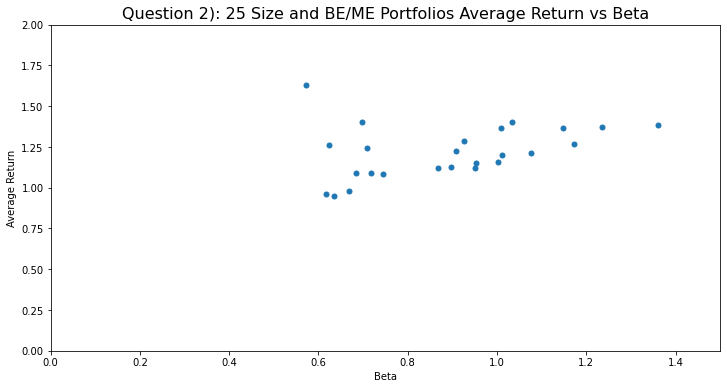

In [ ]:
sheet2_return = pd.read_excel("Problem_Set3.xls", sheet_name='25_Size_BEME_Portfolios', 
                     skiprows=2, index_col=None, usecols="A:Z", na_values=-99.99)
sheet2_return["Date"] = pd.to_datetime(sheet2_return["BE/ME"], format="%Y%m")
s2_return = sheet2_return.set_index("Date")
s2_return = s2_return.loc[s2_return.index.dropna()]
s2_return = s2_return.drop("BE/ME", axis = 1)

sheet2_size = pd.read_excel("Problem_Set3.xls", sheet_name='25_Size_BEME_Portfolios', 
                     skiprows=2, index_col=None, usecols="AB:BA", na_values=-99.99)
sheet2_size["Date"] = pd.to_datetime(sheet2_size["BE/ME.1"], format="%Y%m")
s2_size = sheet2_size.set_index("Date")
s2_size = s2_size.loc[s2_size.index.dropna()]
s2_size = s2_size.drop("BE/ME.1", axis = 1)
s2_size['year'] = s2_size.index.year

sheet2_BEME = pd.read_excel("Problem_Set3.xls", sheet_name='25_Size_BEME_Portfolios', 
                     skiprows=2, index_col=None, usecols="BC:CB", na_values=-99.99)
sheet2_BEME["Date"] = pd.to_datetime(sheet2_BEME["BE/ME.2"], format="%Y")
s2_BEME = sheet2_BEME.set_index("Date")
s2_BEME = s2_BEME.loc[s2_BEME.index.dropna()]
s2_BEME = s2_BEME.drop("BE/ME.2", axis = 1)
s2_BEME['year'] = s2_BEME.index.year

# Repeat part (b)
# merge s1 with s2_return
reg_dt_3 = pd.merge(s1,s2_return, how = 'inner',left_index=True, right_index=True)

# second term with beta coefficient on the RHS of the formula
reg_dt_3.iloc[:, 2:] = reg_dt_3.iloc[:, 2:].subtract(reg_dt_3['RF'], axis = 0)

# average return on the LHS of the formula
avg_return_2 = pd.DataFrame(reg_dt_3.iloc[:, 2:].mean())
avg_return_2.columns = ['avg_return_25 Size']

# estimate betas
beta_2 = []
for pf in avg_return_2.index:
  x = sm.add_constant(reg_dt_3['Mkt-RF'])
  y = reg_dt_3[pf]
  mod4 = sm.OLS(y,x,missing = 'drop').fit()
  beta_2.append(mod4.params[1])

gamma0_2 = []
gamma1_2 = []

x = sm.add_constant(beta_2)
for Date in reg_dt_3.index:
  y = reg_dt_3.loc[Date,:].iloc[2:]
  mod5 = sm.OLS(y,x,missing = 'drop').fit()
  gamma0_2.append(mod5.params[0])
  gamma1_2.append(mod5.params[1])

# merge date, gamma0, gamma1
df_2 = pd.DataFrame({'Date': reg_dt_3.index, 'gamma0':gamma0_2, 'gamma1':gamma1_2})

mean_gamma0_2 = np.mean(gamma0_2)
mean_gamma1_2 =np.mean(gamma1_2)
SE_gamma0_2 = np.std(gamma0_2) / np.sqrt(len(gamma0_2))
SE_gamma1_2 = np.std(gamma1_2)/ np.sqrt(len(gamma1_2))

# t-test
# for gamma0, the test / null hypothesis should be gamma0 = Rf
# for gamma1, the test / null hypothesis should be gamma1 = Rm - Rf
Rf = np.mean(reg_dt_3['RF'])
t_gamma0_2 = (mean_gamma0_2 - Rf) / SE_gamma0_2
t_gamma1_2 = (mean_gamma1_2) / SE_gamma1_2
print("mean of gamma 0: ", mean_gamma0_2, "mean of gamma 1: ", mean_gamma1_2,"SE of gamma0: ", 
      SE_gamma0_2, "SE of gamma1: ", SE_gamma1_2, "t-stat for gamma0: ", t_gamma0_2,
      "t-stat for gamma1: ", t_gamma1_2)

# Repeat part (c)
# OLS regression on avg_return_2 and beta_2
avg_return_2['beta'] = beta_2
avg_return_2

x = sm.add_constant(avg_return_2['beta'])
mod6 = sm.OLS(avg_return_2["avg_return_25 Size"],x, data = avg_return_2).fit()
mod6.summary()

# Repeat part (d)
fig=plt.figure(figsize=(12,6))
plt.plot(avg_return_2['avg_return_25 Size'], avg_return_2['beta'],'.',markersize=10)
plt.xlabel('Beta')
plt.ylabel('Average Return');
plt.title('Question 2): 25 Size and BE/ME Portfolios Average Return vs Beta', fontsize=16)
plt.xlim(0, 1.5)
plt.ylim(0, 2)

# Repeat part (f)
# Lag size and BE/ME
# We merge s3_size and s3_BEME to make the Part I f) implementation easier
# It would be a left join with key "year"
s2_size_BEME  = pd.merge(s2_size, s2_BEME, 'left', on = 'year')

# Lagging
# https://stackoverflow.com/questions/51136283/pandas-insert-empty-row-at-0th-position
temp = pd.DataFrame([[np.nan] * len(s2_size_BEME.columns)], columns=s2_size_BEME.columns)
s2_size_BEME_lag = temp.append(s2_size_BEME, ignore_index=True)
s2_size_BEME_lag = s2_size_BEME_lag.drop(1073)
s2_size_BEME_lag.index = s2_size.index
s2_size_BEME_lag = s2_size_BEME_lag.drop('year', axis = 1)

for Date in s2_size_BEME_lag.index:
    if Date.year == 1926:
        s2_size_BEME_lag.loc[Date].iloc[25:50] = np.nan
        continue
    s2_size_BEME_lag.loc[Date].iloc[25:50] = s2_BEME.loc[str(Date.year-1)+'-01-01'].iloc[0:25]
    
gamma0_size_BEME_25 = []
gamma1_size_BEME_25 = []
gamma2_size_BEME_25 = []
gamma3_size_BEME_25 = []

reg_dt_4 = pd.merge(reg_dt_3, s2_size_BEME_lag, how = 'inner',left_index=True, right_index=True)

size_BEME_return_25 = avg_return_2.copy()
size_BEME_return_25 = size_BEME_return_25.rename(columns={'avg_return': 'size_BEME_return'})

for Date in reg_dt_4.index:
    temp1 = reg_dt_4.loc[Date,:].iloc[27:52]
    if temp1.isnull().sum() == 25:
        continue
    temp1.index = temp1.index.str.replace('.5', '')
    temp1.index = temp1.index.str.replace('.6', '.1')
    temp1.index = temp1.index.str.replace('.7', '.2')
    temp1.index = temp1.index.str.replace('.8', '.3')
    temp1.index = temp1.index.str.replace('.9', '.4')
    size_BEME_return_25['ln(size)'] = np.log(temp1)
    temp2 = reg_dt_4.loc[Date,:].iloc[52:77]
    if temp2.isnull().sum() == 25:
        continue
    temp2.index = temp2.index.str.replace('.10', '')
    temp2.index = temp2.index.str.replace('.11', '.1')
    temp2.index = temp2.index.str.replace('.12', '.2')
    temp2.index = temp2.index.str.replace('.13', '.3')
    temp2.index = temp2.index.str.replace('.14', '.4')
    size_BEME_return_25['ln(BEME)'] = np.log(temp2)
    size_BEME_return_25['size_BEME_return'] = reg_dt_4.loc[Date,:].iloc[2:27]
    y = size_BEME_return_25['size_BEME_return']
    x = sm.add_constant(size_BEME_return_25['beta'])
    x['ln(size)'] = size_BEME_return_25['ln(size)']
    x['ln(BEME)'] = size_BEME_return_25['ln(BEME)']
    mod7 = sm.OLS(y, x, missing = 'drop').fit()
    gamma0_size_BEME_25.append(mod7.params[0])
    gamma1_size_BEME_25.append(mod7.params[1])
    gamma2_size_BEME_25.append(mod7.params[2])
    gamma3_size_BEME_25.append(mod7.params[3])
    
mean_gamma0_size_BEME_25 = np.mean(gamma0_size_BEME_25)
mean_gamma1_size_BEME_25 = np.mean(gamma1_size_BEME_25)
mean_gamma2_size_BEME_25 = np.mean(gamma2_size_BEME_25)
mean_gamma3_size_BEME_25 = np.mean(gamma3_size_BEME_25)
SE_gamma0_size_BEME_25 = np.std(gamma0_size_BEME_25) / np.sqrt(len(gamma0_size_BEME_25))
SE_gamma1_size_BEME_25 = np.std(gamma1_size_BEME_25) / np.sqrt(len(gamma1_size_BEME_25))
SE_gamma2_size_BEME_25 = np.std(gamma2_size_BEME_25) / np.sqrt(len(gamma2_size_BEME_25))
SE_gamma3_size_BEME_25 = np.std(gamma3_size_BEME_25) / np.sqrt(len(gamma3_size_BEME_25))

# t-test
# for gamma0, the null hypothesis should be gamma0 = Rf
# for gamma1, the null hypothesis should be gamma1 = 0, with alternative hypothesis being gamma1 > 0
# for gamma2, the null hypothesis should be gamma3 = 0
# for gamma3, the null hypothesis should be gamma4 = 0
t_gamma0_size_BEME_25 = (mean_gamma0_size_BEME_25 - Rf) / SE_gamma0_size_BEME_25
t_gamma1_size_BEME_25 = mean_gamma1_size_BEME_25 / SE_gamma1_size_BEME_25
t_gamma2_size_BEME_25 = mean_gamma2_size_BEME_25 / SE_gamma2_size_BEME_25
t_gamma3_size_BEME_25 = mean_gamma3_size_BEME_25 / SE_gamma3_size_BEME_25
size_BEME_params_25 = pd.DataFrame({'mean': [mean_gamma0_size_BEME_25, 
        mean_gamma1_size_BEME_25, mean_gamma2_size_BEME_25, mean_gamma3_size_BEME_25], 
        'standard error': [SE_gamma0_size_BEME_25, SE_gamma1_size_BEME_25, SE_gamma2_size_BEME_25,
        SE_gamma3_size_BEME_25], 't-stats':[t_gamma0_size_BEME_25, t_gamma1_size_BEME_25, 
        t_gamma2_size_BEME_25, t_gamma3_size_BEME_25]})
size_BEME_params_25

In [ ]:
mod6.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     avg_return_25 Size   R-squared:                       0.119
Model:                            OLS   Adj. R-squared:                  0.081
Method:                 Least Squares   F-statistic:                     3.103
Date:                Tue, 22 Sep 2020   Prob (F-statistic):             0.0915
Time:                        03:01:02   Log-Likelihood:                 4.9536
No. Observations:                  25   AIC:                            -5.907
Df Residuals:                      23   BIC:                            -3.469
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.3281      0.321      1.022      0.317      -0.336       0.992
beta           0.4604      0.261      1.761      0.091      -0.080       1.001
==============================================================================
Omnibus:                        1.228   Durbin-Watson:                   1.287
Prob(Omnibus):                  0.541   Jarque-Bera (JB):                0.567
Skew:                          -0.366   Prob(JB):                        0.753
Kurtosis:                       3.098   Cond. No.                         15.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Conclusion for part (b): We fail to reject the hypothesis that the proxy for the market portfolio is mean variance efficient because t-stat for both gamma coefficients are less than the critical value. 

Conclusion for part (c): Both gamma coefficients are the same from both methods, but with different SE.  By comparing the SE in (b) and OLS regression from (c), we determine that the cross-sectional regression has less SE and therefore is superior method.

Conclusion for part (f): Given the table of t-stat of model coefficients, at least one of them is less than the t-critical value. Therefore, we fail to reject the null hypotehsis that the proxy for the market portfolio is mean-variance efficient. 

## 2)	Repeat parts c) and d) above
 for the 25 size and BE/ME portfolios using the tangency portfolio (computed in sample using the sample mean and covariance matrix of the 25 portfolios over the entire sample) of the 25 size and BE/ME portfolios instead of the market portfolio.

a.	First, compute the tangency weights for the 25 portfolios.
$$
\frac{V^{-1}\left(R-r_{f} 1\right)}{1^{\prime} V^{-1}\left(R-r_{f}\right)}
$$
b.	Then reconstruct the returns of the tangency portfolio over time and use this for RM to estimate the betas.



In [ ]:
# a. tangency weight
s2_return_invcov_T = np.linalg.inv(s2_return.cov()) # inverse cov. matrix, (25,25)
R = s2_return.mean() # (25,)
rf = s1['RF'].mean() # scalar
ones = np.transpose([1]*len(s2_return.columns.tolist())) # (25,)
onesT = np.transpose(ones) # (25,)

num = s2_return_invcov_T @ (R - rf * ones) 
denom = onesT @ s2_return_invcov_T @ (R - rf)
weight_tang = num/denom # (25,)

mean of gamma 0:  -0.00420568564572304 mean of gamma 1:  2.5211274940551194 SE of gamma0:  0.1987476463594341 SE of gamma1:  0.45631866832007134 t-stat for gamma0:  -1.4349531946965148 t-stat for gamma1:  5.524927356876726


(0.2, 0.6)

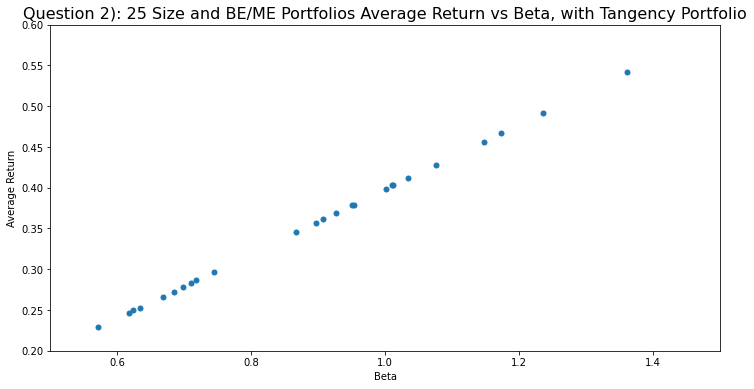

In [ ]:
# b. reconstruct the returns of the tangency portfolio over time and recalculated beta
new_RM = s2_return @ weight_tang
new_s1 = s1.copy()
new_s1['Mkt-RF'] = new_RM - s1['RF']

# Repeat part (b)
# merge new_s1 with s2_return
reg_dt_5 = pd.merge(new_s1, s2_return, how = 'inner',left_index=True, right_index=True)

# second term with beta coefficient on the RHS of the formula
reg_dt_5.iloc[:, 2:] = reg_dt_5.iloc[:, 2:].subtract(reg_dt_5['RF'], axis = 0)

# average return on the LHS of the formula
avg_return_3 = pd.DataFrame(reg_dt_5.iloc[:, 2:].mean())
avg_return_3.columns = ['avg_return_25 Size']

# estimate betas
beta_3 = []
for pf in avg_return_3.index:
  x = sm.add_constant(reg_dt_5['Mkt-RF'])
  y = reg_dt_5[pf]
  mod8 = sm.OLS(y, x, missing = 'drop').fit()
  beta_3.append(mod8.params[1])

gamma0_3 = []
gamma1_3 = []

x = sm.add_constant(beta_3)
for Date in reg_dt_5.index:
  y = reg_dt_5.loc[Date,:].iloc[2:]
  mod9 = sm.OLS(y, x, missing = 'drop').fit()
  gamma0_3.append(mod9.params[0])
  gamma1_3.append(mod9.params[1])

# merge date, gamma0, gamma1
df_3 = pd.DataFrame({'Date': reg_dt_5.index, 'gamma0':gamma0_3, 'gamma1':gamma1_3})

mean_gamma0_3 = np.mean(gamma0_3)
mean_gamma1_3 =np.mean(gamma1_3)
SE_gamma0_3 = np.std(gamma0_3) / np.sqrt(len(gamma0_3))
SE_gamma1_3 = np.std(gamma1_3)/ np.sqrt(len(gamma1_3))

# t-test
# for gamma0, the test / null hypothesis should be gamma0 = Rf
# for gamma1, the test / null hypothesis should be gamma1 = Rm - Rf
Rf = np.mean(reg_dt_5['RF'])
t_gamma0_3 = (mean_gamma0_3 - Rf) / SE_gamma0_3
t_gamma1_3 = (mean_gamma1_3) / SE_gamma1_3
print("mean of gamma 0: ", mean_gamma0_3, "mean of gamma 1: ", mean_gamma1_3,"SE of gamma0: ", 
      SE_gamma0_3, "SE of gamma1: ", SE_gamma1_3, "t-stat for gamma0: ", t_gamma0_3,
      "t-stat for gamma1: ", t_gamma1_3)

# Repeat part (c)
# OLS regression on avg_return_2 and beta_2
avg_return_3['beta'] = beta_3
avg_return_3

x = sm.add_constant(avg_return_3['beta'])
mod10 = sm.OLS(avg_return_3["avg_return_25 Size"],x, data = avg_return_3).fit()
mod10.summary()

# Repeat part (d)
fig=plt.figure(figsize=(12,6))
plt.plot(avg_return_3['avg_return_25 Size'], avg_return_3['beta'],'.',markersize=10)
plt.xlabel('Beta')
plt.ylabel('Average Return');
plt.title('Question 2): 25 Size and BE/ME Portfolios Average Return vs Beta, with Tangency Portfolio', fontsize=16)
plt.xlim(0.5, 1.5)
plt.ylim(0.2, 0.6)

Conclusion for part (c): we fail to reject the null hypothesis when $\alpha = 0.05$ because t-stat for gamma0 is less than t-crit. 

c.	How do the results highlight the Roll (1977) critique of tests of the CAPM?

From the result above, we can see that there is a clear linear relationship between Beta and Average Return. In fact, the regression model indicates that the R-squred of the model is precisely 1.0, meaning that Beta alone explains all of the Average Return.

This highlights Roll's critique of test of the CAPM that the only testable hypothesis is that the market portfolio is mean-variance efficient. In the test we did above, our market return is precisely constructed by using the tangency portfolio and therefore we know it is mean-variance efficient. With this setup, our test shows that the Average Return and Beta relationship lies entirely on a linear relation, indicating that it is not independently testable.

## 3)	Repeat parts c) and d) above for the 25 size and BE/ME portfolios, only this time use the following tangency portfolio of the 25 size and BE/ME portfolios, where we split the data in half and use one half to estimate the portfolio weights and the other half to measure portfolio returns using those weights. 

First, split the sample into two halves:  (1) take all observations from odd months in even years and even months in odd years (i.e., if starting in 1980, this would look like:  01/1980, 03/1980, . . . , 11/1980, 02/1981, 04/1981, . . . 12/1981, 01/1982, 03/1982, . . .); and (2) the opposite (take all observations from even months in even years and odd months in odd years).

a.	Then, compute the tangency portfolio weights for the 25 portfolios using only the moments estimated from the first sample and apply them to returns in the second sample.

b.	Then, do the reverse---compute the tangency portfolio weights from the second sample and apply those to returns in the first sample.

c.	The resulting return series is your new tangency portfolio returns which you will use to repeat the cross-sectional tests.


In [ ]:
# Split the sample
same_yr_month = []
diff_yr_month = []
for i, data in s2_return.iterrows():
  if int(i.year) % 2 == 0:
    if int(i.month) % 2 == 0:
      same_yr_month.append(data)
    else:
      diff_yr_month.append(data)
  else:
    if int(i.month) % 2 == 0:
      diff_yr_month.append(data)
    else:
      same_yr_month.append(data)

diff_ = pd.DataFrame(diff_yr_month) # first half of data sample; odd in even, even in odd
same_ = pd.DataFrame(same_yr_month) # second half of data sample; even in even, odd in odd

mean of gamma 0:  0.055063380243006284 mean of gamma 1:  3.134432879296589 SE of gamma0:  0.1858391173531981 SE of gamma1:  0.6216627967639194 t-stat for gamma0:  -1.2156994039299651 t-stat for gamma1:  5.042014570620848


(0.1, 0.6)

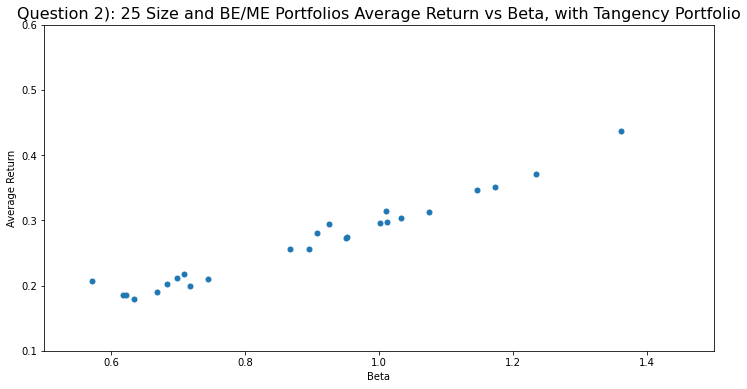

In [ ]:
# a. tangency weight using first sample
diff_invcov_T = np.linalg.inv(diff_.cov()) # inverse cov. matrix, (25,25)
R = diff_.mean() # (25,)
rf = s1['RF'].mean() # scalar
ones = np.transpose([1]*len(diff_.columns.tolist())) # (25,)
onesT = np.transpose(ones) # (25,)

num = diff_invcov_T @ (R - rf * ones) 
denom = onesT @ diff_invcov_T @ (R - rf)
weight_tang = num/denom # (25,)

# apply weights to the return in the second sample
new_RM = same_ @ weight_tang

# b. tangency weights from the second sample
same_invcov_T = np.linalg.inv(same_.cov()) # inverse cov. matrix, (25,25)
R = same_.mean() # (25,)
rf = s1['RF'].mean() # scalar
ones = np.transpose([1]*len(same_.columns.tolist())) # (25,)
onesT = np.transpose(ones) # (25,)

num = same_invcov_T @ (R - rf * ones) 
denom = onesT @ same_invcov_T @ (R - rf)
weight_tang = num/denom # (25,)

# apply weights to returns in the first sample
new_RM2 = diff_ @ weight_tang

# c. concatenate two return series and set it as our new tangency portfolio returns 
RM_concat = pd.concat([new_RM,new_RM2])
new_s1 = s1.copy()
new_s1['Mkt-RF'] = RM_concat - s1['RF']

# Repeat part (b)
# merge new_s1 with s2_return
reg_dt_5 = pd.merge(new_s1, s2_return, how = 'inner',left_index=True, right_index=True)

# second term with beta coefficient on the RHS of the formula
reg_dt_5.iloc[:, 2:] = reg_dt_5.iloc[:, 2:].subtract(reg_dt_5['RF'], axis = 0)

# average return on the LHS of the formula
avg_return_3 = pd.DataFrame(reg_dt_5.iloc[:, 2:].mean())
avg_return_3.columns = ['avg_return_25 Size']

# estimate betas
beta_3 = []
for pf in avg_return_3.index:
  x = sm.add_constant(reg_dt_5['Mkt-RF'])
  y = reg_dt_5[pf]
  mod8 = sm.OLS(y, x, missing = 'drop').fit()
  beta_3.append(mod8.params[1])

gamma0_3 = []
gamma1_3 = []

x = sm.add_constant(beta_3)
for Date in reg_dt_5.index:
  y = reg_dt_5.loc[Date,:].iloc[2:]
  mod9 = sm.OLS(y, x, missing = 'drop').fit()
  gamma0_3.append(mod9.params[0])
  gamma1_3.append(mod9.params[1])

# merge date, gamma0, gamma1
df_3 = pd.DataFrame({'Date': reg_dt_5.index, 'gamma0':gamma0_3, 'gamma1':gamma1_3})

mean_gamma0_3 = np.mean(gamma0_3)
mean_gamma1_3 =np.mean(gamma1_3)
SE_gamma0_3 = np.std(gamma0_3) / np.sqrt(len(gamma0_3))
SE_gamma1_3 = np.std(gamma1_3)/ np.sqrt(len(gamma1_3))

# t-test
# for gamma0, the test / null hypothesis should be gamma0 = Rf
# for gamma1, the test / null hypothesis should be gamma1 = Rm - Rf
Rf = np.mean(reg_dt_5['RF'])
t_gamma0_3 = (mean_gamma0_3 - Rf) / SE_gamma0_3
t_gamma1_3 = (mean_gamma1_3) / SE_gamma1_3
print("mean of gamma 0: ", mean_gamma0_3, "mean of gamma 1: ", mean_gamma1_3,"SE of gamma0: ", 
      SE_gamma0_3, "SE of gamma1: ", SE_gamma1_3, "t-stat for gamma0: ", t_gamma0_3,
      "t-stat for gamma1: ", t_gamma1_3)

# Repeat part (c)
# OLS regression on avg_return_2 and beta_2
avg_return_3['beta'] = beta_3
avg_return_3

x = sm.add_constant(avg_return_3['beta'])
mod10 = sm.OLS(avg_return_3["avg_return_25 Size"],x, data = avg_return_3).fit()
mod10.summary()

# Repeat part (d)
fig=plt.figure(figsize=(12,6))
plt.plot(avg_return_3['avg_return_25 Size'], avg_return_3['beta'],'.',markersize=10)
plt.xlabel('Beta')
plt.ylabel('Average Return');
plt.title('Question 2): 25 Size and BE/ME Portfolios Average Return vs Beta, with Tangency Portfolio', fontsize=16)
plt.xlim(0.5, 1.5)
plt.ylim(0.1, 0.6)

Conclusion for part (c): we fail to reject the null hypothesis when $\alpha = 0.05$ because t-stat for gamma0 is less than t-crit. 

## 4)	How are the results different between 2) and 3) and why?  How does the difference in results between 2) and 3) showcase the Roll (1977) critique?

Both (2) and (3) show linear relationship between beta and average return. Part (2) use the tangency portfolio of the original return, which gives a perfectly linear result (R-squared = 1); part (3) split the data for odd months / even years and even months / odd years, then derive the tangency return separately before combining for the new return, which gives a slightly less perfect linear relationship (R-squared = 0.97).

While in part (3) we're still using the tangency portfolio, providing that our return are mean-variance efficient, the splitting of data makes the two tangency portfolios slightly different. This slight difference results in a less than perfect linear relationship, and showcases Roll's critique that the CAPM model relies extensively on the mean-variance efficient market portfolio, and that the result is very sensitive to even a slight difference for the market portfolio.
